In [11]:
%use Python3 -c white
import matplotlib.pyplot as plt

## Table of contents <a name="toc"></a>

1. [Introduction](#introduction)
2. [Résultat principal](#résultat)
    1. [Binarisation](#binarisation)
    2. [Choix des caractéristiques](#choix)
    3. [Séparation train/test](#split)
    4. [Complexité](#complexité)
    5. [Etude des règles obtenues](#règles)
    6. [Performances](#score)
3. [Influence des caractéristiques](#binarisation_influence)
4. [Optimisation bi-objectif](#biobjectif)
5. [Comparaison à des méthodes de machine learning usuelles](#compML)
6. [Influence de la séparation train/test](#compSplit)
7. [Méthode ORC appliquée à du multi-classes](#multiclasses)

## Introduction <a name="introduction"></a>

Nous cherchons à prédire si un patient a une maladie rénale chronique à partir de différentes données et des résultats d'analyses médicales.

Nous avons à notre disposition les données de 189 patients. Chacun est décrit par 24 caractéristiques.

L'objectif principal est de mettre en oeuvre un algorithme ORC (règles ordonnées pour la classification) pour réaliser cette prédiction.

In [2]:
import pandas as pd

data = pd.read_csv('data/kidney.csv')

data.head(5)

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,70,1.005,4,0,abnormal,present,notpresent,117,56,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,53,90,1.020,2,0,abnormal,present,notpresent,70,107,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
2,63,70,1.010,3,0,abnormal,present,notpresent,380,60,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
3,68,70,1.015,3,1,normal,present,notpresent,208,72,...,28,12200,3.4,yes,yes,yes,poor,yes,no,ckd
4,68,80,1.010,3,2,abnormal,present,present,157,90,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd


## Résultat principal <a name="résultat"></a>

### Binarisation <a name="binarisation"></a>

La méthode ORC fonctionne avec des données binaires. Nous devons donc binariser notre jeu de données.

Toutes les caractéristiques qui ne peuvent prendre que deux valeurs possibles sont transformées en une colonne à valeurs égales à 1 ou 0. Par exemple la colonne "ane" qui indique si le patient a une anémie ou non peut prendre la valeur "yes" ou "no". Ainsi nous faisons correspondre "no" à 0 et "yes" à 1.

Certaines caractéristiques qui prennent "x" valeurs discrètes sont transformées en x colonnes. Une colonne est associée à une valeur et ne prend des 1 que pour les patients qui ont cette valeur là de la caractéristique.

Pour binariser les autres caractéristiques (celles qui prennent des valeurs réelles), nous traçons l'histogramme de cette caractéristique et nous nous basons sur ce graphique pour le choix des intervalles de valeurs que nous allons considérer et pour lesquels nous allons créer une nouvelle colonne binanire.


#### Exemple
Dans les histogrammes suivants, les lignes rouges verticales indiquent la séparation que nous avons choisi de prendre en compte dans la binarisation.

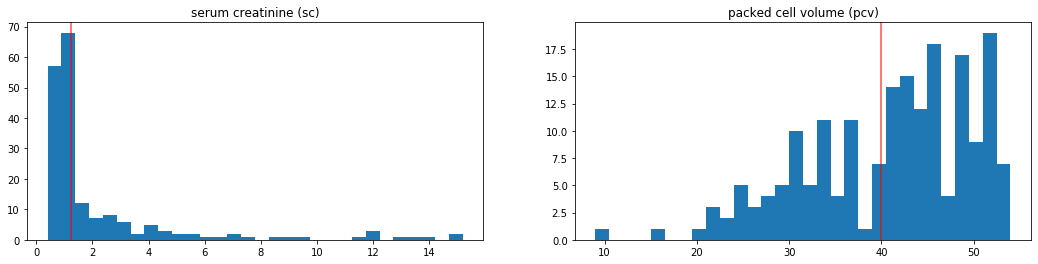

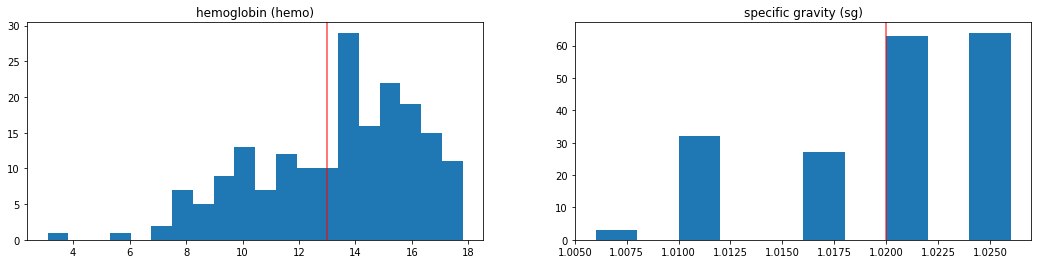

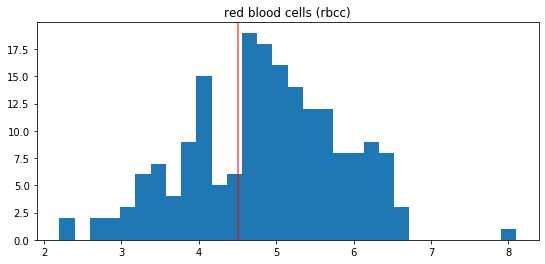

In [3]:
plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(data['sc'], bins=30)
plt.axvline(1.25,0,70, color='r', alpha=0.7)
plt.title('serum creatinine (sc)')

plt.subplot(122)
plt.hist(data['pcv'], bins=30)
plt.axvline(40,0,20, color='r', alpha=0.7)
plt.title('packed cell volume (pcv)')
plt.show()

plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(data['hemo'], bins=20)
plt.axvline(13,0,16, color='r', alpha=0.7)
plt.title('hemoglobin (hemo)')

plt.subplot(122)
plt.hist(data['sg'], bins=10,align='right')
plt.axvline(1.02,0,60, color='r', alpha=0.7)
plt.title('specific gravity (sg)')
plt.show()

plt.figure(figsize=(9,4))
plt.hist(data['rbcc'], bins=30,align='right')
plt.axvline(4.5,0,20, color='r', alpha=0.7)
plt.title('red blood cells (rbcc)')
plt.show()

#### En pratique
 
Si un ensemble de valeurs ont des fréquences similaires alors on les mets dans une même catégorie.

Nous séparons la colonne sc (serum creatinine) en deux colonnes sc0-1.25 et sc1.25-Inf. Si un patient a une valeur de serum creatinine compris entre 0 et 1.25 (exclus) il aura 1 dans la colonne sc0-1.25 et 0 dans la colonne sc1.25-Inf (et inversement).

### Choix des caractéristiques <a name="choix"></a>

Pour commencer, nous avons regardé les corrélations entre les différentes variables. Comme nous le remarquons sur le graphique ci-dessous, les plus grosses corrélations à la maladie sont principalement sg (specific gravity), hemo (hemoglobin), pcv (packed cell volume), rbcc (red blood cells), htn (hypertension), dm (diabetes mellitus) et al (albumin).  

<img src="img/corr_plot.png" width="500"/>

Nous avons également entraîné un modèle de forêt aléatoire et analysé les importances des variables dans cette forêt (voir figure ci-dessous). Nous trouvons cette fois-ci 4 variables qui se détachent : sg, pcv et hemo (présentes dans les variables les  plus corrélées à la classe) mais également sc (serum creatinine). Les variables suivantes sont rbcc, htn, dm et al qui étaient les plus corrélées également, selon les deux indicateurs d'importance.

<img src="img/var_importance.png" width="500"/>

Ainsi, pour une première approche, nous avons utilisé ces 8 variables comme caractéristiques. Pour les binariser, nous avons analysé les histogrammes des variables continues sur tout le dataset, sur le dataset restreint aux patients malades et sur le dataset restreint aux patients sains. La comparaison des 3 histogrammes nous permet éventuellement d'identifier des seuils pertinents de binarisation. Par exemple, pour sg :

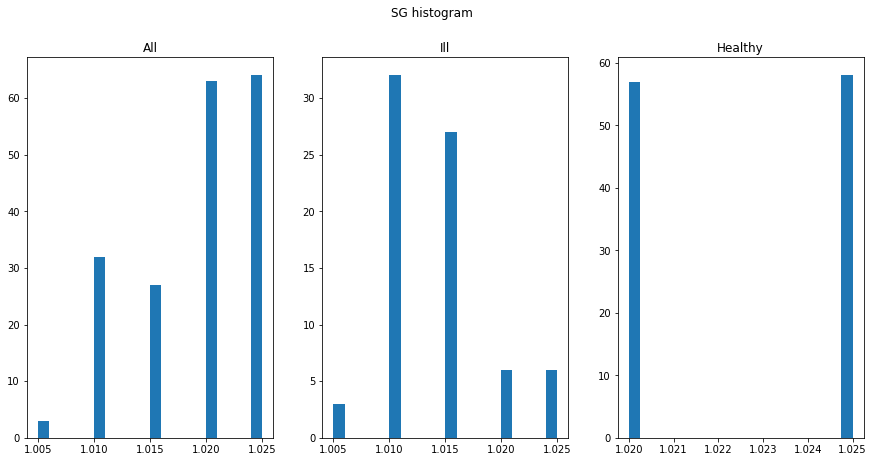

In [4]:
data_ill = data[data['class'] == 'ckd']
data_healthy = data[data['class'] == 'notckd']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,7))
fig.suptitle('SG histogram')
ax1.hist(data['sg'], bins=20)
ax1.set_title('All')
ax2.hist(data_ill['sg'], bins=20)
ax2.set_title('Ill')
ax3.hist(data_healthy['sg'], bins=20)
ax3.set_title('Healthy')
plt.show()

Nous remarquons que tous les patients sains ont un sg de 1.02 ou de 1.025 mais jamais moins, alors que parmi les patients malades, la majeure partie a moins de 1.02 de sg. Ainsi, nous binarisons sg entre 0 et 1.02 exclus, et 1.02 et l'infini (soit ici 1.025).

Nous avons entraîné plusieurs fois l'ORC avec ces caractéristiques et analysé les règles obtenues à chaque fois. Il s'est avéré que plusieurs caractéristiques n'étaient jamais utiles et nous avons donc décidé de les supprimer. Finalement, notre set final de caractéristique était donc :

- sg0-1.02 et sg1.02-Inf
- pcv0-40 et pcv40-Inf
- hemo0-13 et hemo13-Inf
- sc0-1.25 et sc1.25-Inf
- rbcc0-4.5 et rbcc4.5-Inf
- dm qui vaut 1 si il y a présence de dm

### Séparation train/test <a name="split"></a>

Le jeu de données à notre disposition est assez petit et surtout, la classe malade représentant bien moins de la moitié des données:

In [14]:
print("Proportion de patients malades :", len(data_ill)/len(data)*100, "%")

Proportion de patients malades : 39.15343915343915 %


Nous avons donc décidé de modifier la façon dont nous séparons notre jeu en échantillons d'apprentissage et de test, afin de forcer ceux-ci à contenir en proportions équivalentes à celles du dataset d'origine les patients sains et malades. Ceci s'effectue en fixant la variable booléenne ```respectProp``` à ```true``` dans le fichier ```main.jl```. Sinon, il sépare comme initialement de manière aléatoire. 

### Complexité <a name="complexité"></a>

### Etude des règles obtenues <a name="règles"></a>

### Performances <a name="score"></a>

In [9]:
include("src/main.jl")

=== Warning: Existing features found, features creation skipped
=== Loading existing features
=== ... 126 individuals in the train set
=== ... 63 individuals in the test set
=== ... 13 features
=== Warning: Existing rules found, rules creation skipped
=== Loading the existing rules
=== ... 77 rules obtained
=== Warning: Sorted rules found, sorting of the rules skipped
=== Loading the sorting rules
=== Results
-- Train results
Class	Prec.	Recall	Size
0	1.0	1.0	65
1	1.0	1.0	61


avg	1.0	1.0
w. avg	1.0	1.0

-- Test results
Class	Prec.	Recall	Size
0	1.0	1.0	50
1	1.0	1.0	13


avg	1.0	1.0
w. avg	1.0	1.0



Sur cet exemple nous constatons que la méthode ORC avec ces caractéristiques est très performante puisqu'elle obtient les précisions et rappels maxima pour toutes les classes à la fois sur le train et sur le test. 

Comme il peut y avoir une certaine variabilité dûe aux observations présentes ou non dans le train, nous avons effectué 10 éxecutions distinctes. Les résultats obtenus sont les suivants :

Retour au [sommaire](#toc).

## Influence des caractéristiques <a name="binarisation_influence"></a>

Nous allons comparer l'ajout et la suppression d'une caractéristique sur les performances du classifieur.

Retour au [sommaire](#toc).

## Optimisation bi-objectif <a name="biobjectif"></a>

Nous allons résoudre le problème de génération de règle par l'optimisation bi-objectif où nous minimisons la couverture de la règle et maximisons le nombre d'éléments d'une certaine classe pour lesquels la règle s'applique. Nous récupérons donc pour chaque classe un ensemble de règles non dominées.

### Observations

Cette méthode est beaucoup plus rapide même si nous binarisons plus de caractéristiques. Et ceci donne peu de règles à appliquer.

Retour au [sommaire](#toc).

## Comparaison à des méthodes de machine learning usuelles <a name="compML"></a>

Nous avons testés des méthodes usuelles en machine learning sur ce problème : arbre CART (CART), forêt aléatoire (RF), Support Vector Classifier (SVC), Adaptive Boosting (AdaBoost).

Nous avons comparé ces différentes méthodes avec le classifieur ORC et ceci sur 10 combinaisons différentes train/test (les mêmes que pour la comparaison avec le bi-objectif). Les train/test sont les mêmes pour toutes les méthodes à chaque exécution, ce qui veut dire que les méthodes ne voient que les caractéristiques telles que nous les avons binarisées, afin de comparer sur les mêmes échantillons du fait de la variabilité dûe au faible nombre de données. Les résultats obtenus sont les suivants :

__INSERER TABLEAUX__

Nous remarquons que les méthodes de machine learning usuelles les plus interprétables (arbre CART et forêt aléatoire) sont moins performantes qu'ORC, même si bien plus rapide. SVC quant à lui est extrêmement rapide et hyper performant, mais très peu interprétable ! Nous retrouvons le compromis classique performance/interprétabilité, et nous constatons bien que nous avons amélioré le pouvoir prédictif de l'arbre CART en conservant le même niveau d'interprétabilité. 

Petite précision : si nous utilisons tout le jeu de donnée brut, alors nous retrouvons de meilleures performances avec la forêt aléatoire. Elle ne peut en effet pas tirer profit de si peu de variables. 

__INSERER TABLEAU__

Retour au [sommaire](#toc).

## Méthode ORC appliquée à du multi-classes <a name="multiclasses"></a>

Le classifieur ORC s'applique si on s'intéresse à faire du multi-classes. Ceci vient du fait que pour chaque classe nous pouvons générer des règles qui s'appliquent à cette classe là. En effet, la génération de règles s'effectue classe après classe, et rien n'impose la binarité de la classe : pour chaque classe possible, nous générons des règles correspondantes. 

Nous avons testé ceci sur la prédiction de la valeur de sg (specific gravity) qui contient 5 valeurs différentes possibles. Pour plus de lisibilité, nous avons modifié ces valeurs possibles de sg :

- 1.005 est représenté par la classe 0 ;
- 1.01 est représenté par la classe 1 ;
- 1.015 est représenté par la classe 2 ;
- 1.02 est représenté par la classe 3 ;
- 1.025 est représenté par la classe 4.

La création du nouveau dataset est effectuée dans le fichier ```create_multiclass.py```.

In [10]:
include("src/mainMultiClass.jl")

=== Warning: Existing features found, features creation skipped
=== Loading existing features
=== ... 126 individuals in the train set
=== ... 63 individuals in the test set
=== ... 20 features
=== Warning: Existing rules found, rules creation skipped
=== Loading the existing rules
=== ... 39 rules obtained
=== Warning: Sorted rules found, sorting of the rules skipped
=== Loading the sorting rules
=== Results
-- Train results
Class	Prec.	Recall	Size
0	0.5	1.0	2
1	0.85	0.55	20
2	0.53	0.89	18
3	0.61	0.61	44
4	0.6	0.5	42


avg	0.62	0.71
w. avg	0.63	0.61

-- Test results
Class	Prec.	Recall	Size
0	NaN	0.0	1
1	0.6	0.5	12
2	0.33	0.33	9
3	0.45	0.47	19
4	0.46	0.5	22


avg	NaN	0.36
w. avg	NaN	0.46



Nota bene : nous avons ici créé un deuxième main spécifique au multiclasse simplement pour pouvoir afficher les résultats facilement dans le notebook. En pratique, ce main est inutile et il suffit d'utiliser le main principal en changeant ```dataSet = "kidney"``` par ```dataSet = "multiclass"```.

Nous avons donc adapté la fonction ```showStatistics``` pour un  nombre quelconque de classes. Les définitions de la précision et du rappel s'adaptent sans ambiguité à du multiclasse.

Retour au [sommaire](#toc).